In [3]:
import os
import sys
from collections import OrderedDict
import csv
import math
from itertools import product
import numpy as np
from scipy.stats import ks_2samp, mannwhitneyu
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torchvision.transforms import ToTensor
sys.path.append("/Users/andreachatrian/Documents/Repositories/ProstateCancer")
from phenotyping.models import VAE
from mymodel.utils import get_flags
from generative.utils import segmap2img
from pix2pix_cyclegan.models import create_model

In [2]:
vae_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results" + \
            "/models/vae_gan/gtvae2018_10_10_23_56_57/ckpt/" + \
            "epoch_.3991_rec_loss_398118.46354_enc_loss_0.27605_dec_loss_0.10399_dis_loss_0.37233G.pth"

In [3]:
# Maintain checkpoint dir / snapshot structure
vae_snapshot = os.path.basename(vae_file)
vae_chkpt_dir = os.path.dirname(vae_file)

# Load VAE-GAN
file_name = os.path.join(vae_chkpt_dir, os.path.basename(os.path.dirname(vae_chkpt_dir))[5:]) + ".txt"
LOADEDFLAGS = get_flags(file_name)
num_filt_gen = LOADEDFLAGS.num_filt_gen
num_filt_discr = LOADEDFLAGS.num_filt_discr
num_lat_dim = LOADEDFLAGS.num_lat_dim
image_size = LOADEDFLAGS.image_size
print("Loaded settings of old model - ngf: {}, ndf: {}, nz: {}".format(num_filt_gen,
                                                                       num_filt_discr,
                                                                       num_lat_dim))
num_channels = 4
vae = VAE(image_size, 0, num_filt_gen, num_lat_dim, num_channels=num_channels)
state_dict_G = torch.load(vae_file, map_location="cpu")
state_dict_G = {key[7:]: value for key, value in state_dict_G.items()}  # remove data_parallel's "module."
vae.load_state_dict(state_dict_G)
vae.eval()

Loaded settings of old model - ngf: 27, ndf: 12, nz: 4480


VAE(
  (sampler): _Sampler()
  (encoder): _Encoder(
    (encoder): Sequential(
      (input-conv): Conv2d(4, 27, kernel_size=(3, 3), stride=(1, 1))
      (input-relu): LeakyReLU(negative_slope=0.01)
      (conv_0): Conv2d(27, 54, kernel_size=(3, 3), stride=(1, 1))
      (dropout_0): Dropout(p=0.3)
      (norm_0): InstanceNorm2d(54, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu_0): LeakyReLU(negative_slope=0.01)
      (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv_1): Conv2d(54, 108, kernel_size=(3, 3), stride=(1, 1))
      (dropout_1): Dropout(p=0.3)
      (norm_1): InstanceNorm2d(108, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu_1): LeakyReLU(negative_slope=0.01)
      (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv_2): Conv2d(108, 216, kernel_size=(3, 3), stride=(1, 1))
      (dropout_2): Dropout(p=0.3)
      (norm_2): InstanceNorm2d(216, eps=1e-05, momentum=0.1, affine=False, trac

In [55]:
mus_dir = "/Volumes/A-CH-EXDISK/Projects/Results/test_repr/mus"
logvar_dir = "/Volumes/A-CH-EXDISK/Projects/Results/test_repr/logvars"
mu_files = os.listdir(mus_dir)
logvar_files = os.listdir(logvar_dir)

mus, logvars = OrderedDict(), OrderedDict()
for mu_file, logvar_file in zip(mu_files, logvar_files):
    mus[mu_file] = np.load(os.path.join(mus_dir, mu_file))
    logvars[logvar_file] = np.load(os.path.join(logvar_dir, logvar_file))

In [56]:
mu_path, mu = next(iter(mus.items()))
logvar_path, logvar = next(iter(logvars.items()))
print(mu.shape, logvar.shape)
print(mu_path, logvar_path)


(8, 8, 140) (8, 8, 140)
mu_0.0046_gland_img_36_(1090,1111).png.npy logvar_0.0046_gland_img_36_(1090,1111).png.npy


In [57]:
X_mus = np.array([mu.flatten() for mu in mus.values()])
X_logvars = np.array([logvar.flatten() for logvar in logvars.values()])
X = np.concatenate((X_mus, X_logvars), axis=1)
pca = PCA(n_components=10, whiten=True)
X_pca = pca.fit_transform(X)

In [22]:
sns.set(style="darkgrid")
plt.plot(pca.explained_variance_ratio_)

In [58]:
idx0 = X_pca[:, 0].argmin()
idx1 = X_pca[:, 0].argmax()
mu0 = list(mus.values())[idx0]
logvar0 = list(logvars.values())[1700]
mu1 = list(mus.values())[idx1]
logvar1 = list(logvars.values())[idx1]
print(idx0, idx1)
print(logvar0[0][0][0])

1836 1976
0.041007627


In [59]:
# Sampling variation
recs0, recs1 = [], []
recs_t0, recs_t1 = [], []
n = 0
N = 6
fig, axes = plt.subplots(2, N, figsize=(10, 5))
std0 = np.exp(logvar0 * 0.5)
std1 = np.exp(logvar1 * 0.5)
for eps in range(-50, 51, 20):
    eps *= 0.1
    sampled0 = ToTensor()(eps * std0 + mu0)
    sampled1 = ToTensor()(eps * std1 + mu1)
    sampled = torch.stack((sampled0, sampled1), dim=0)
    with torch.no_grad():
        reconstructed = vae.decoder(sampled)
    rec_imgs = segmap2img(reconstructed, return_tensors=False, size=256)
    recs_tens = segmap2img(reconstructed, return_tensors=True, size=256)
    recs0.append(rec_imgs[0])
    recs1.append(rec_imgs[1])
    recs_t0.append(recs_tens[0])
    recs_t1.append(recs_tens[1])
    axes[0, n].imshow(rec_imgs[0])
    axes[0, n].grid(False)
    axes[0, n].set_xticks([])
    axes[0, n].set_yticks([])
    axes[0, n].set_title("$\epsilon$: {:.2f}".format(eps))
    axes[1, n].imshow(rec_imgs[1])
    axes[1, n].grid(False)
    axes[1, n].set_xticks([])
    axes[1, n].set_yticks([])
    axes[1, n].set_title("$\epsilon$: {:.2f}".format(eps))
    n += 1

/Users/andreachatrian/miniconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/Users/andreachatrian/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [10]:
recs_t0 = torch.stack(recs_t0)
recs_t1 = torch.stack(recs_t1)
np.savez(os.path.join(os.path.dirname(mus_dir),
                      "eps_sample.npz"), 
         recs0=recs_t0.numpy(), recs1=recs_t1.numpy())

In [ ]:
np.savez(os.path.join(os.path.dirname(mus_dir),
                      "eps_sample_img.npz"), 
         recs0=recs0, recs1=recs1)

In [85]:
# Make figure
transformed_path = "/Volumes/A-CH-EXDISK/Projects/Results/test_repr/"
rec0_pix2pixed = [file_path for file_path in os.listdir(transformed_path) if file_path.startswith("rec0") and \
                  file_path.endswith("fake_B.png")]
rec0_pix2pixed = [imageio.imread(os.path.join(transformed_path, img_path)) for img_path in rec0_pix2pixed]
rec1_pix2pixed = [file for file in os.listdir(transformed_path) if file.startswith("rec1") and \
                  file.endswith("fake_B.png")]
rec1_pix2pixed = [imageio.imread(os.path.join(transformed_path, img_path)) for img_path in rec1_pix2pixed]

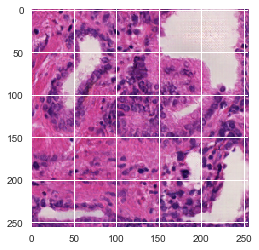

In [12]:
plt.imshow(rec0_pix2pixed[0])

In [86]:
%matplotlib
fig, axes = plt.subplots(4, N, figsize=(10, 7))
eps = list(range(-50, 51, 20))
    
for i in range(N):
    eps[i] *= 0.1
    i = i+1
    axes[0, i].imshow(recs0[i])
    axes[0, i].grid(False)
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[0, i].set_title("$\epsilon$: {:.2f}".format(eps[i]), fontsize=20)

for i in range(N):
    axes[1, i].imshow(rec0_pix2pixed[i])
    axes[1, i].grid(False)
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
for i in range(N):
    axes[2, i].imshow(recs1[i])
    axes[2, i].grid(False)
    axes[2, i].set_xticks([])
    axes[2, i].set_yticks([])    

for i in range(N):
    eps[i] *= 0.1
    axes[3, i].imshow(rec1_pix2pixed[i])
    axes[3, i].grid(False)
    axes[3, i].set_xticks([])
    axes[3, i].set_yticks([])
    #axes[1, i].set_title("$\epsilon$: {:.2f}".format(eps[i]), fontsize=20)
    



Using matplotlib backend: MacOSX


IndexError: index 4 is out of bounds for axis 1 with size 4

In [15]:
   
# # Variation across principal components
# N = 10
# pca_mu = PCA(n_components=3, whiten=True)
# X_mu_stats = np.array([mu.mean(axis=2).flatten() for mu in mus.values()])
# X_pca_mu = pca_mu.fit_transform(X_mu_stats)
# sort_idx = np.argsort(X_pca_mu[:, 0])
# fig, axes = plt.subplots(1, N, figsize=(20, 4))
# mus_sorted = np.array(list(mus.values()))[sort_idx]
# print(mus_sorted.shape)
# mus_t = torch.from_numpy(mus_sorted).permute(0,3,1,2)
# logvar_t = torch.from_numpy(logvars_sorted).permute(0,3,1,2)
# with torch.no_grad():
#     reconstructed, sampled = vae.sample_from(mus_t, logvar_t)
# rec_imgs = segmap2img(reconstructed, return_tensors=False, size=256)
# space = np.linspace(0,N, N, endpoint=False, dtype=int)
# for i, sp in enumerate(space):
#     axes[i].imshow(rec_imgs[sp]) 

(2309, 8, 8, 140)


NameError: name 'logvars_sorted' is not defined

In [ ]:
# # Variation across principal components
# N = 16
# pca_logvar = PCA(n_components=3, whiten=True)
# X_logvar_stats = np.array([logvar.mean(axis=2).flatten() for mu in logvars.values()])
# X_pca_logvar = pca_logvar.fit_transform(X_logvar_stats)
# sort_idx = np.argsort(X_pca_logvar[:, 0])
# fig, axes = plt.subplots(1, N, figsize=(20, 4))
# logvar_sorted = np.array(list(logvars.values()))[sort_idx]
# print(mus_sorted.shape)
# mus_t = torch.from_numpy(mus_sorted).permute(0,3,1,2)
# logvar_t = torch.from_numpy(logvars_sorted).permute(0,3,1,2)
# with torch.no_grad():
#     reconstructed, sampled = vae.sample_from(mus_t, logvar_t)
# rec_imgs = segmap2img(reconstructed, return_tensors=False, size=256)
# space = np.linspace(0, len(mus_sorted), N, endpoint=False, dtype=int)
# for i, sp in enumerate(space):
#     axes[i].imshow(rec_imgs[sp])


In [5]:
# AREAS comparison:
with open('/Volumes/A-CH-EXDISK/Projects/Results/test_areas.tsv', 'r') as areas_file:
    rd = csv.reader(areas_file, delimiter='\t')
    lines = iter(rd)
    real_ck5neg = [float(el) for el in next(lines)[1:]]
    real_ck5pos = [float(el) for el in next(lines)[1:]]
    rec_ck5neg = [float(el) for el in next(lines)[1:]]
    rec_ck5pos = [float(el) for el in next(lines)[1:]]
print(len(real_ck5neg), len(real_ck5pos), len(rec_ck5neg), len(rec_ck5pos))

1391 166 918 132


In [14]:
%matplotlib
sns.set(style="darkgrid")
real_areas = real_ck5neg + real_ck5pos
rec_areas = rec_ck5neg + rec_ck5pos
hist_min, hist_max = min(real_areas), max(real_areas)
log_real_areas = [math.log10(el) for el in real_areas]
log_rec_areas = [math.log10(el) for el in rec_areas]
#hist_reals, bins = np.histogram(log_real_areas, 20, (math.log10(hist_min), math.log10(hist_max)))
palette = sns.hls_palette(2, l=.5, s=.6)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
(n_real, bins, patches) = axes[0].hist(log_real_areas, bins='auto', color=palette[0])
(n_fake, _, _) = axes[1].hist(log_rec_areas, bins=bins, color=palette[1])
axes[0].set_title('Real glands', fontsize=18)
axes[0].set_ylabel('n', fontsize=15)
axes[0].set_xlabel('$log_{10}$(area)', fontsize=18)
plt.setp(axes[0].get_xticklabels(), fontsize=12)
plt.setp(axes[0].get_yticklabels(), fontsize=12)
axes[1].set_title('Generated glands', fontsize=18)
axes[1].set_ylabel('n', fontsize=15)
axes[1].set_xlabel('$log_{10}$(area)', fontsize=18)
axes[1].set_ylim((0, max(n_real)))
plt.setp(axes[1].get_xticklabels(), fontsize=12)
plt.setp(axes[1].get_yticklabels(), fontsize=12)

Using matplotlib backend: MacOSX


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [79]:
test_dir = os.path.dirname(mus_dir)
fig.savefig(os.path.join(test_dir, 'area_hists.pdf'), bbox_inches='tight')

In [ ]:
D, pks = ks_2samp(real_areas, rec_areas) 

In [ ]:
print("D = {}; p = {}".format(D,p))

In [83]:
recs0_fake = []
recs0_real = []
recs1_fake = []
recs1_real = []
rec_name0 = "rec0_{}_"
rec_name1 = "rec1_{}_"
for i in range(6):
    recs0_real.append(imageio.imread(os.path.join(test_dir, rec_name0.format(i) + "real_A.png")))
    recs0_fake.append(imageio.imread(os.path.join(test_dir, rec_name0.format(i) + "fake_B.png")))
    recs1_real.append(imageio.imread(os.path.join(test_dir, rec_name1.format(i) + "real_A.png")))
    recs1_fake.append(imageio.imread(os.path.join(test_dir, rec_name1.format(i) + "fake_B.png")))


In [106]:
N = 4
fig, axes = plt.subplots(2, N, figsize=(10, 6))
eps = list(range(-50, 51, 20))
plt.tight_layout()
for i in range(1, N+1):
    eps[i] *= 0.1
    j = i - 1
    print(i, j)
    axes[0, j].imshow(recs0_real[i])
    axes[0, j].grid(False)
    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])
    axes[0, j].set_title("$\epsilon$: {:.2f}".format(eps[i]), fontsize=20)

    axes[1, j].imshow(recs0_fake[i])
    axes[1, j].grid(False)
    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])
    
#     axes[2, j].imshow(recs1_real[i])
#     axes[2, j].grid(False)
#     axes[2, j].set_xticks([])
#     axes[2, j].set_yticks([])    

#     axes[3, j].imshow(recs1_fake[i])
#     axes[3, j].grid(False)
#     axes[3, j].set_xticks([])
#     axes[3, j].set_yticks([])
    

1 0
2 1
3 2
4 3


In [107]:
fig.savefig(os.path.join(test_dir, 'glands.pdf'), bbox_inches='tight')